### Data Analytics notebook - housing data
---

#### **Dataset name / short description:**
Kansas City Housing sales data.

#### **Data source (url):**
https://www.kaggle.com/datasets/astronautelvis/kc-house-data

#### **Data format:**
Single csv-file.

#### **Data description, features and limitations:**
The dataset contains housing data from Kansas City, USA. Time period May 2014 - May 2015. Approximately 21000+ buildings in total. Each building has information about square footage, view, waterfront, bedrooms, bathrooms, condition and grade.

The data is limited in the US area of Kansas City and years 2014-2015.

#### **Code: importing modules, custom functions and loading tha data.**

In [1]:
# typical imports
import numpy as np 
import pandas as pd
import seaborn as sns 
from scipy import stats

# let's create a custom function to create an age group
# from 1-4, 1 => oldest, 4 => newest
def create_age_group(row):
    year = row['yr_built']

    # determine age group based on year built
    if year >= 2000:
        return 4
    elif 1980 <= year < 2000:
        return 3
    elif 1960 <= year < 1980:
        return 2
    else:
        return 1
    
# load a csv-file into a DataFrame
df = pd.read_csv("houses.csv")

#### **Code: Data clean-up:**

In [2]:
# instead of each built year separately, let's have an age group between 1-4
df['age_group'] = df.apply(create_age_group, axis=1)
df = df.drop("yr_built", axis=1)

# let's remove obvious columns that are not needed in data analytics
df = df.drop(["id", "zipcode", "lat", "long"], axis=1)

# convert date to DateTime -object -> get year and month
df['DateTime'] = pd.to_datetime(df['date'])

# get year and month as integer
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month

# drop original timestamps (also the temporary one)
df = df.drop(["date", "DateTime"], axis=1)

# convert square feets to square meters
# this multiplier was Googled earlier
df['living_m2'] = df['sqft_living'] * 0.09290304
df['lot_m2'] = df['sqft_lot'] * 0.09290304
df['above_m2'] = df['sqft_above'] * 0.09290304
df['basement_m2'] = df['sqft_basement'] * 0.09290304
df['living_m2_15'] = df['sqft_living15'] * 0.09290304
df['lot_m2_15'] = df['sqft_lot15'] * 0.09290304

# drop the original square feet columns
df = df.drop(["sqft_living", "sqft_basement", "sqft_lot", "sqft_above", "sqft_living15", "sqft_lot15"], axis=1)

# drop yr_renovated
# if yr_renovated is 0 => replace yr_renovated -value with yr_built -value
df = df.drop("yr_renovated", axis=1)

# also drop the following in order to make it easier for plotting with seaborn
# mostly based on correlations
# waterfront is missing from most data => drop column
# also remove other m2 -fields (since many of them are contained in other columns)
# for example: living_m2 => above_m2 + basement_m2
df = df.drop(["waterfront", "year", "month", "lot_m2", "above_m2", "basement_m2", 'living_m2_15', 'lot_m2_15', "view", "condition"], axis=1)

###

In [3]:
# Data frame seems to be manageable now
df

,price,bedrooms,bathrooms,floors,grade,age_group,living_m2
0,221900.0,3,1.00,1.0,7,1,109.625587
1,538000.0,3,2.25,2.0,7,1,238.760813
2,180000.0,2,1.00,1.0,6,1,71.535341
3,604000.0,4,3.00,1.0,7,2,182.089958
4,510000.0,3,2.00,1.0,8,3,156.077107
...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,3.0,8,4,142.141651
21609,400000.0,4,2.50,2.0,8,4,214.606022
21610,402101.0,2,0.75,2.0,7,4,94.761101
21611,400000.0,3,2.50,2.0,8,4,148.644864


In [4]:
# a common and quick and dirty way to remove all extreme values (outliers)
# basically uses the normal distribution, and all values
# under -3 and over +3 are removed
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

<Axes: >

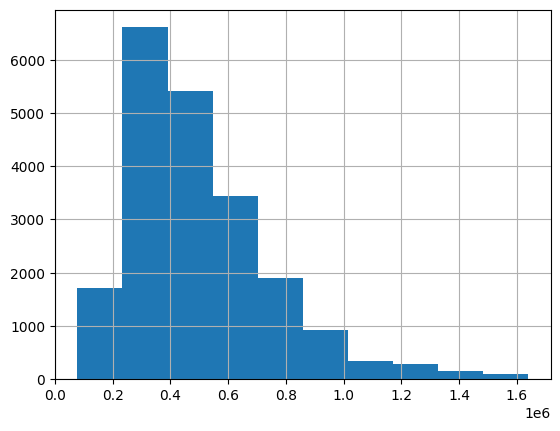

In [5]:
df['price'].hist()

#### **Code: Data analysis:**

In [6]:
# change scientific format to default format
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [7]:
# common statistics
# typical house price 500k$, 3 bedrooms and 2 bathrooms.
# grade 7-8, age group ~2
# typical living m2 = 186m2
df.describe()

,price,bedrooms,bathrooms,floors,grade,age_group,living_m2
count,20899.0,20899.0,20899.0,20899.0,20899.0,20899.0,20899.0
mean,500986.4,3.3,2.1,1.5,7.6,2.3,186.1
std,251028.9,0.9,0.7,0.5,1.1,1.2,72.8
min,78000.0,1.0,0.0,1.0,5.0,1.0,34.4
25%,319900.0,3.0,1.5,1.0,7.0,1.0,131.0
50%,445000.0,3.0,2.2,1.0,7.0,2.0,174.7
75%,623000.0,4.0,2.5,2.0,8.0,3.0,230.4
max,1640000.0,6.0,4.2,3.0,11.0,4.0,445.9


<Axes: >

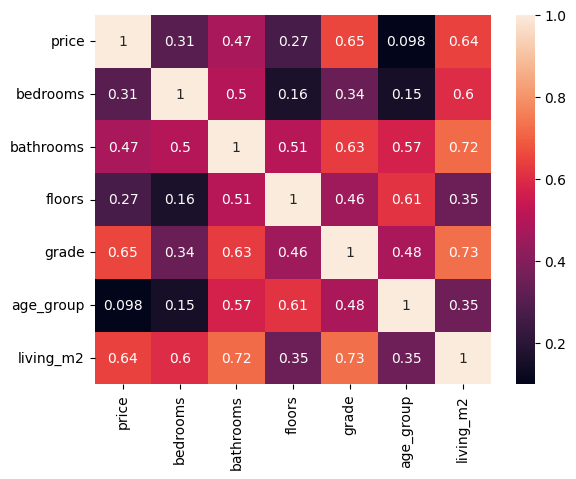

In [8]:
# let's use seaborn for a more visual correlation matrix
# we can see here many things that correlate with price
# bedrooms, bathrooms, grade, living m2 
# age group affects with living m2 but not with price
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True)

In [9]:
# take a sample of 3000 buildings for easier plotting and analyzing
sample = df.sample(3000)

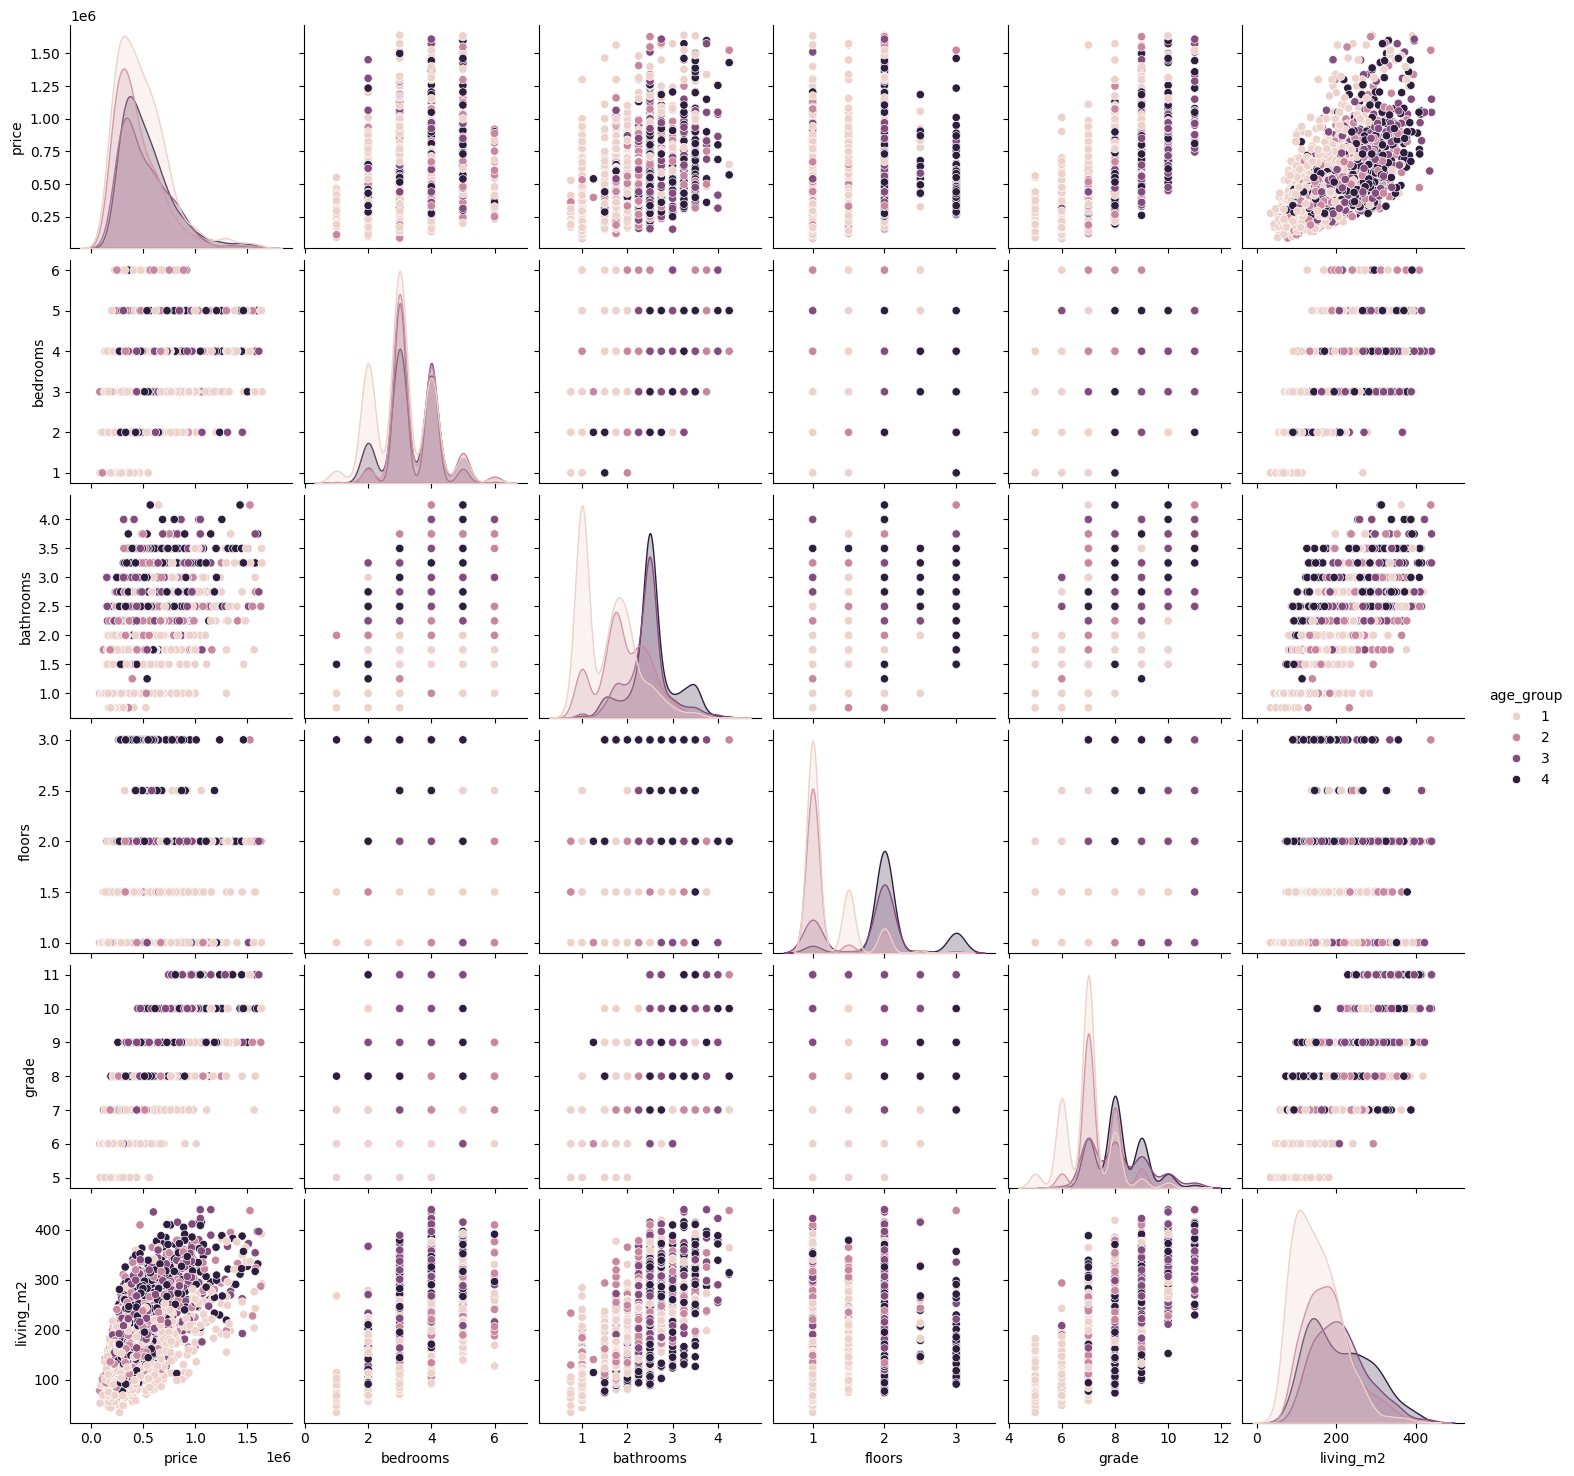

In [10]:
# let's quickly try a pair plot with age group as hue
# in order to see quick correlations better
# you can make more specific plots later
sns.pairplot(sample, hue="age_group")

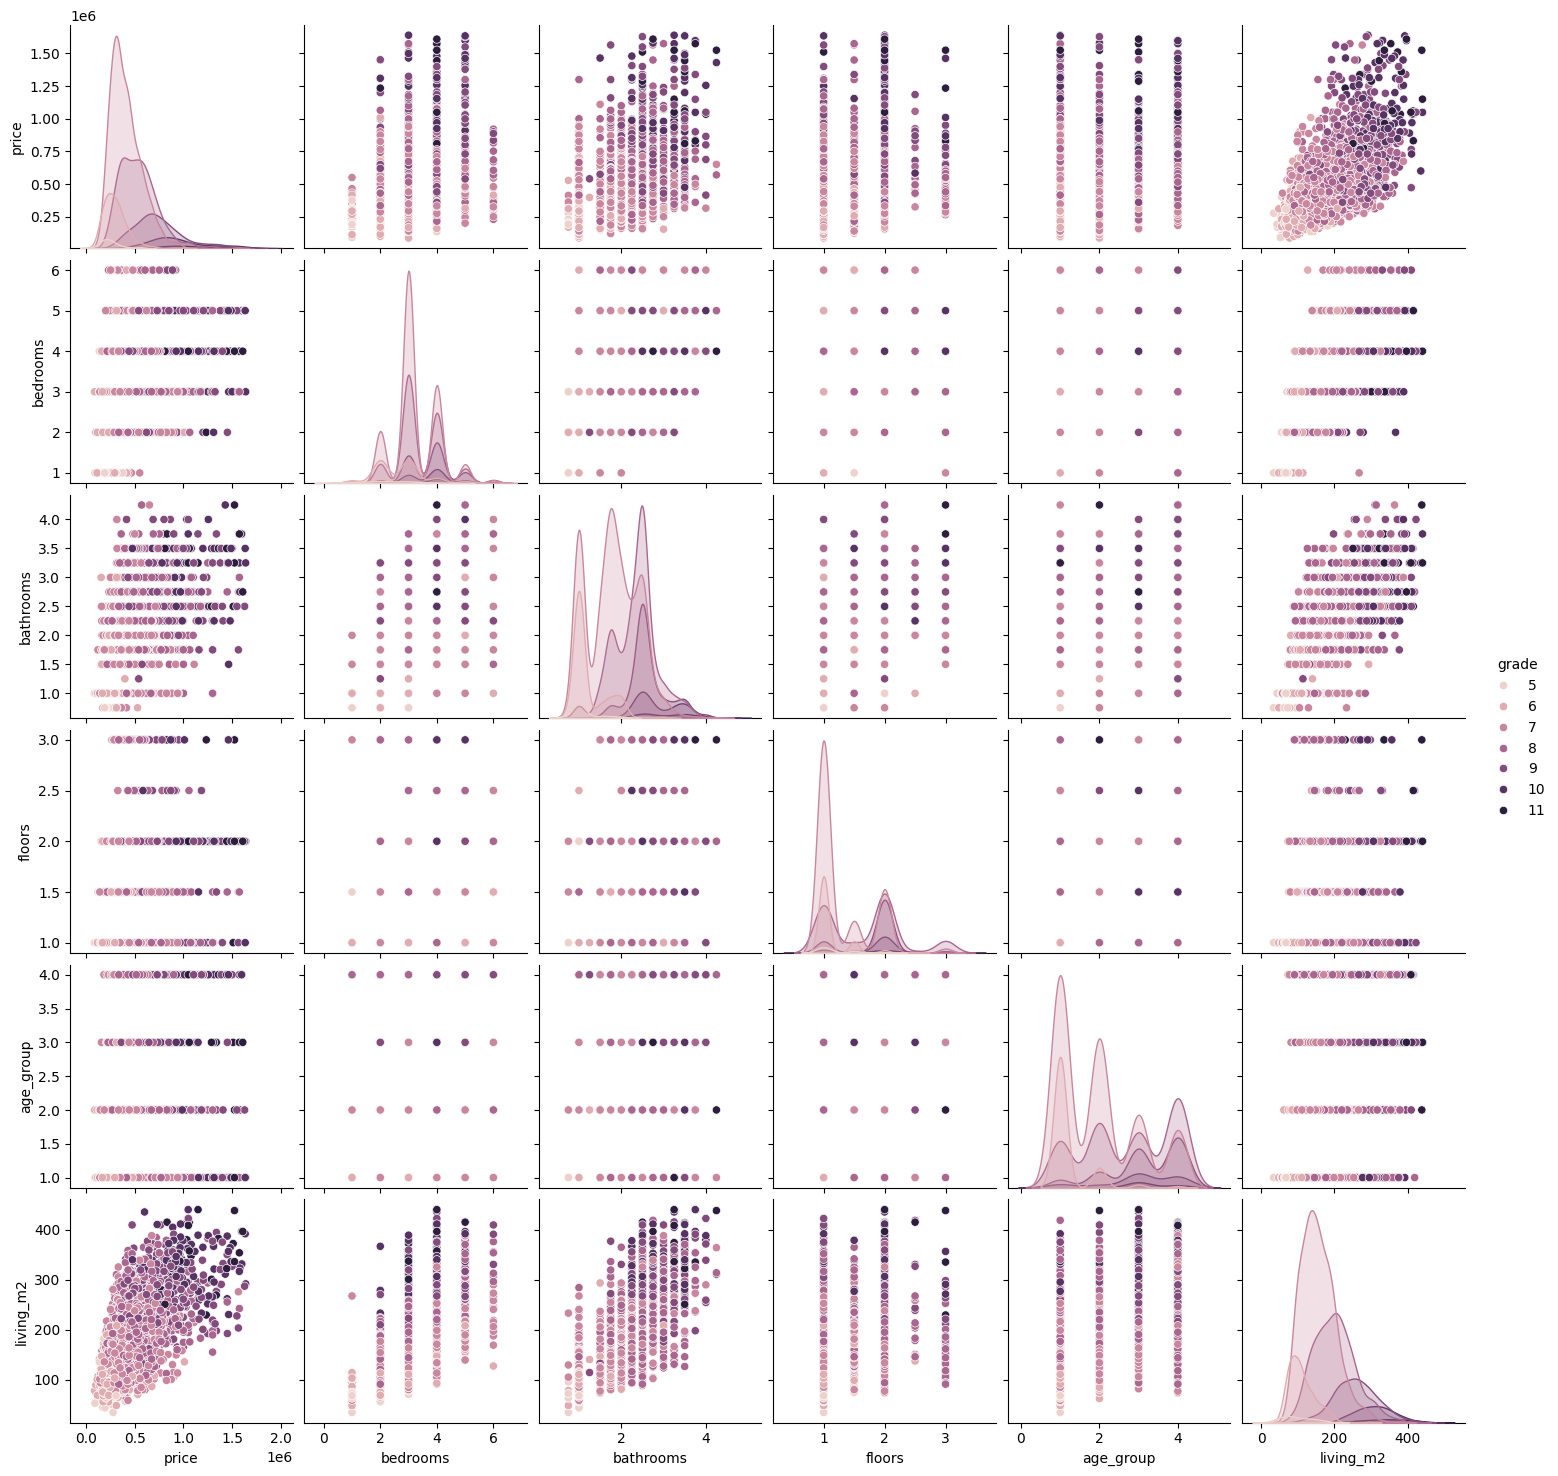

In [11]:
# let's quickly try a pair plot with gradeas hue
# in order to see quick correlations better
# here we can see how price and grade and living_m2 
# correlate heavily with each other
sns.pairplot(sample, hue="grade")

<Axes: xlabel='price', ylabel='Count'>

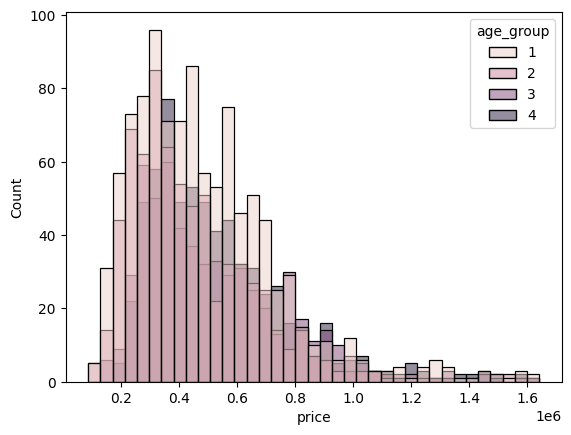

In [12]:
# it seems there are buildings from all age groups
# in all price levels
sns.histplot(x="price", hue="age_group", data=sample)

<Axes: xlabel='living_m2', ylabel='price'>

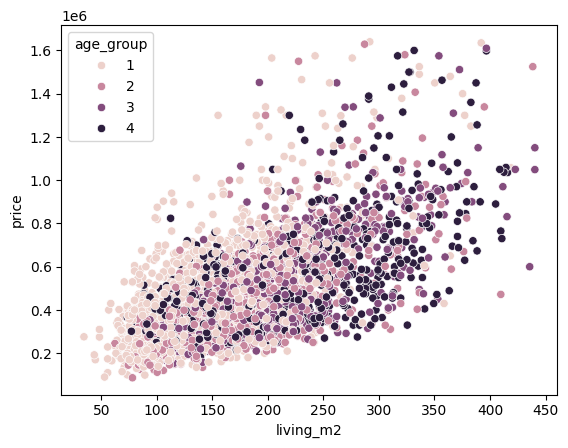

In [13]:
# newer buildings seem to be bigger
# doesn't affect the price though directly
# age group 1 => oldest, 4 => newest
sns.scatterplot(x="living_m2", y="price", hue="age_group", data=sample)

<Axes: xlabel='living_m2', ylabel='price'>

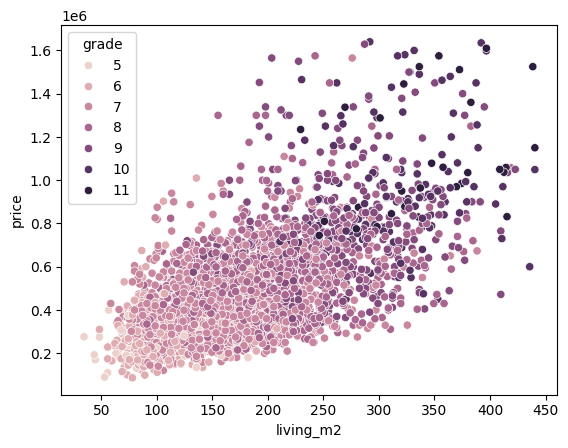

In [14]:
# this shows clearly most of "how the data works"
# price = grade + living_m2 , mostly
sns.scatterplot(x="living_m2", y="price", hue="grade", data=sample)

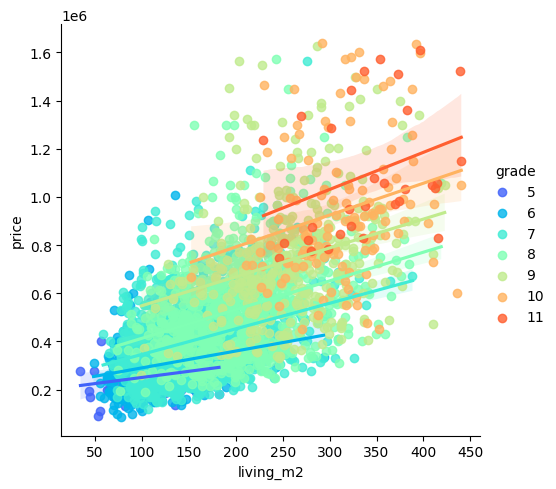

In [15]:
# to show the correlation more clearly
sns.lmplot(x="living_m2", y="price", hue="grade", data=sample, palette="rainbow")

<Axes: xlabel='bathrooms', ylabel='price'>

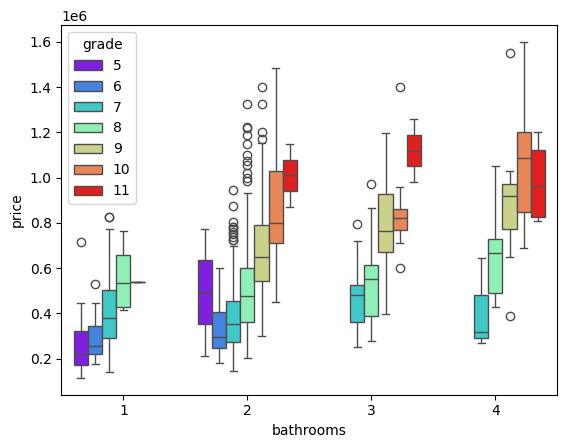

In [16]:
# take a new sample, 1000 buildings
# round bathrooms to nearest integer
# some bathrooms are decimals, probably due to not being 
# fully furbished (not enough mirrors, sinks etc.)
sample = df.sample(1000)
sample['bathrooms'] = round(sample['bathrooms'], 0).astype(int)
sns.boxplot(x="bathrooms", y="price", data=sample, hue="grade", palette="rainbow")

# here we can see that bathroom affects the grade => which affects the price

<Axes: xlabel='bedrooms', ylabel='price'>

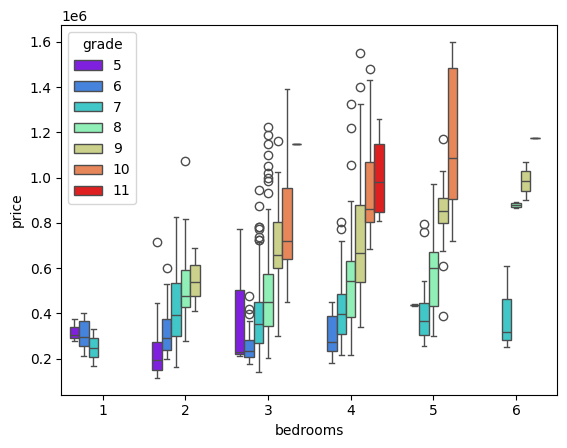

In [17]:
# strangely, bedrooms do not affect that clearly to price
sns.boxplot(x="bedrooms", y="price", data=sample, hue="grade", palette="rainbow")

#### **Results and summary:**

The price of a building on this dataset, seems to be mostly based on number bathrooms, the grade and living square meters. The age of building doesn't affect the price directly, but it affects the living square meters (newer houses are often bigger). Surprisingly, number of bedrooms doesn't seem to directly affect the price in this US housing dataset.

#### **Ideas for further improvement:**

It would be interesting to know if other areas in US work differently and do they have different price levels. Also, it would be interesting to compare European house market to US house market.

Combining this dataset with other location data would be interesting: using the zipcode, lat/long, could we find more information about different areas, if some areas are cheaper or more expensive. Could we find a correlation between certain areas and price levels?

More historical data from more years would be interesting.